In [13]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import builtins
from torchinfo import summary
from torch.utils.data import DataLoader

In [14]:
default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
def load_mnist(batch_size=64):
    builtins.data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
    builtins.data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())
    builtins.train_loader = DataLoader(builtins.data_train, batch_size=batch_size)
    builtins.test_loader = DataLoader(builtins.data_test, batch_size=batch_size)
    
load_mnist()

In [24]:
def load_cifar_10():
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    builtins.trainset = torchvision.datasets.CIFAR10('./data', download=True, train=True, transform=transform)
    builtins.trainloader = torch.utils.data.DataLoader(builtins.trainset, batch_size=14, shuffle=True)
    builtins.testset = torchvision.datasets.CIFAR10('./data', download=True, train=False, transform=transform)
    builtins.testloader = torch.utils.data.DataLoader(builtins.testset, batch_size=14, shuffle=False)

    builtins.classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

load_cifar_10()

Files already downloaded and verified
Files already downloaded and verified


In [17]:
print(trainset[0][0])

tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0000,  ..., -0

In [18]:
def display_datasets(dataset, n=10, classes=None):
    fig, ax = plt.subplots(1, n, figsize=(15, 3))
    mn = min([dataset[i][0].min() for i in range(n)])
    mx = max([dataset[i][0].max() for i in range(n)])
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn), (1, 2, 0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])

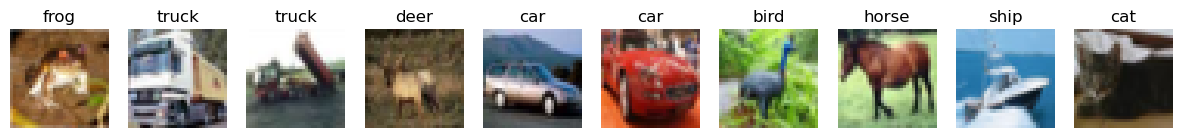

In [19]:
display_datasets(trainset, n=10, classes=classes)

In [20]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net = LeNet()

summary(net, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

In [21]:
def train(net, train_loader, test_loader, optimizer=None, lr=0.01, epochs=10, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net, train_loader, optimizer=optimizer, lr=lr, loss_fn=loss_fn)
        vl, va = validate(net, test_loader, loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc:{ta:.3f}, Val acc={va:.3f}, Train loss:{tl:.3f}, Val loss:{vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)

    return res

In [28]:
def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    total_loss, acc, count = 0, 0, 0
    for features, labels in dataloader:
        optimizer.zero_grad()
        lbls = labels.to(default_device)
        out = net(features.to(default_device))
        loss = loss_fn(out, lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, predicted = torch.max(out, 1)
        acc += (predicted==lbls).sum()
        count += len(labels)
        print(f"out: {out.shape}; loss={loss}; total_loss:{total_loss}; predicted:{predicted}; acc:{acc}; count:{count}")
        break

    return total_loss/count, acc/count
        

In [23]:
def validate(net, dataloader, loss_fn=nn.NLLLoss()):
    net.eval()
    count, acc, loss = 0, 0, 0
    with torch.no_grad():
        for features, labels in dataloader:
            lbls = labels.to(default_device)
            out = net(features.to(default_device))
            loss += loss_fn(out, lbls)
            pred = torch.max(out, 1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)

    return loss/count, acc/count

In [29]:
opt = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())



out: torch.Size([14, 10]); loss=0.7123064398765564; total_loss:0.7123064398765564; predicted:tensor([1, 3, 3, 0, 5, 6, 0, 1, 1, 5, 6, 7, 8, 0]); acc:12; count:14
Epoch  0, Train acc:0.857, Val acc=0.547, Train loss:0.051, Val loss:0.094
out: torch.Size([14, 10]); loss=0.8283872604370117; total_loss:0.8283872604370117; predicted:tensor([5, 0, 7, 0, 4, 6, 1, 3, 8, 5, 7, 7, 6, 0]); acc:10; count:14
Epoch  1, Train acc:0.714, Val acc=0.548, Train loss:0.059, Val loss:0.094
out: torch.Size([14, 10]); loss=0.8448919653892517; total_loss:0.8448919653892517; predicted:tensor([9, 1, 2, 1, 0, 0, 8, 9, 7, 3, 7, 3, 4, 3]); acc:9; count:14
Epoch  2, Train acc:0.643, Val acc=0.550, Train loss:0.060, Val loss:0.094
